In [ ]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    !unzip "/content/drive/MyDrive/Colab Notebooks/Image/sd.zip" -d /content
    !pip install pytorch-lightning  

In [24]:
import numpy as np
from matplotlib import pyplot as plt

import torchvision as tv
from torchvision.transforms.functional import pil_to_tensor
import torch
from torch import nn
from torchsummary import summary
from torch.nn import functional as F
import pytorch_lightning as pl

In [25]:
show = tv.transforms.ToPILImage()

In [26]:
def uncompose_label(label):
    label = label[0, ...]
    unq = np.unique(label)
    n = len(unq) - 1
    
    masks = torch.empty([n, *label.shape], dtype=torch.bool)
    
    for i in range(n):
        masks[i] = (label == unq[i+1])
    return masks

## Prepare Dataset

### Dataset

In [27]:
import PIL
import os

class AmougDataset(tv.datasets.VisionDataset):
    def __len__(self):
        # count number of file which start with img
        return sum(file_name.startswith("img") for file_name in os.listdir("sd"))

    def __getitem__(self, index: int):
        # Load the image and mask
        img_path = os.path.join(self.root, f"img{index}.png")
        mask_path = os.path.join(self.root, f"label{index}.png")

        img = PIL.Image.open(img_path).convert("RGB")
        mask = PIL.Image.open(mask_path)
        mask = pil_to_tensor(mask)
        
        # Split color encoded image into binary masks
        obj_ids = torch.unique(mask)[1:]
        num_objs = len(obj_ids)
        masks = mask == obj_ids[:, None, None]

        # Get bounding box coordinate from mask
        boxes=tv.ops.masks_to_boxes(masks)

        # Construct a target
        target = {
            'boxes': boxes,
            'labels': torch.ones((num_objs,), dtype=torch.int64), # there is only amougus
            'masks': masks,
            'image_id': torch.tensor([index]),
        }

        # Apply transforms
        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

In [28]:
train_ds = AmougDataset("sd", transform=tv.transforms.ToTensor())

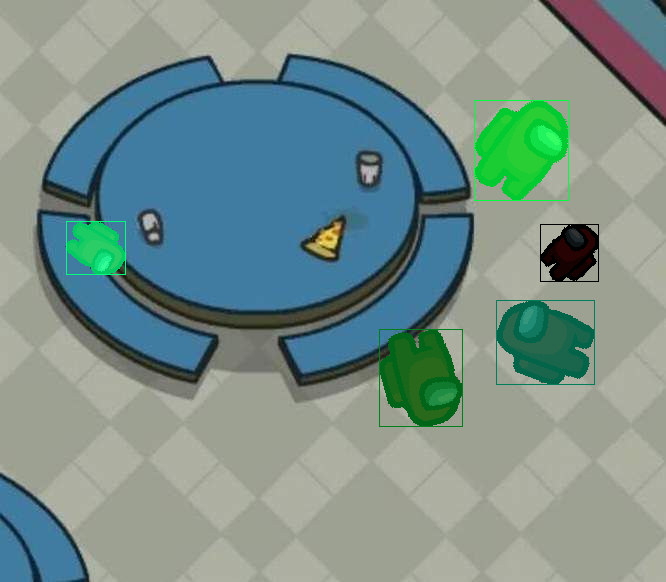

In [29]:
img, target = train_ds[0]
img = show(img)

visual = tv.utils.draw_bounding_boxes(pil_to_tensor(img), target['boxes'])
visual = tv.utils.draw_segmentation_masks(visual, target['masks'])
show(visual)

### Data Loader

In [30]:
def collate_fn(batch):
    # https://github.com/pytorch/vision/blob/4a310f26049371959617921d0eb9b001f4d262c6/references/detection/utils.py#L203
    imgs, targets = tuple(zip(*batch))
    imgs = torch.stack(imgs)
    return imgs, targets

train_data = torch.utils.data.DataLoader(train_ds, batch_size=4, collate_fn=collate_fn)

In [31]:
# Take a sample batch for testing purposes

sample_batch = next(iter(train_data))

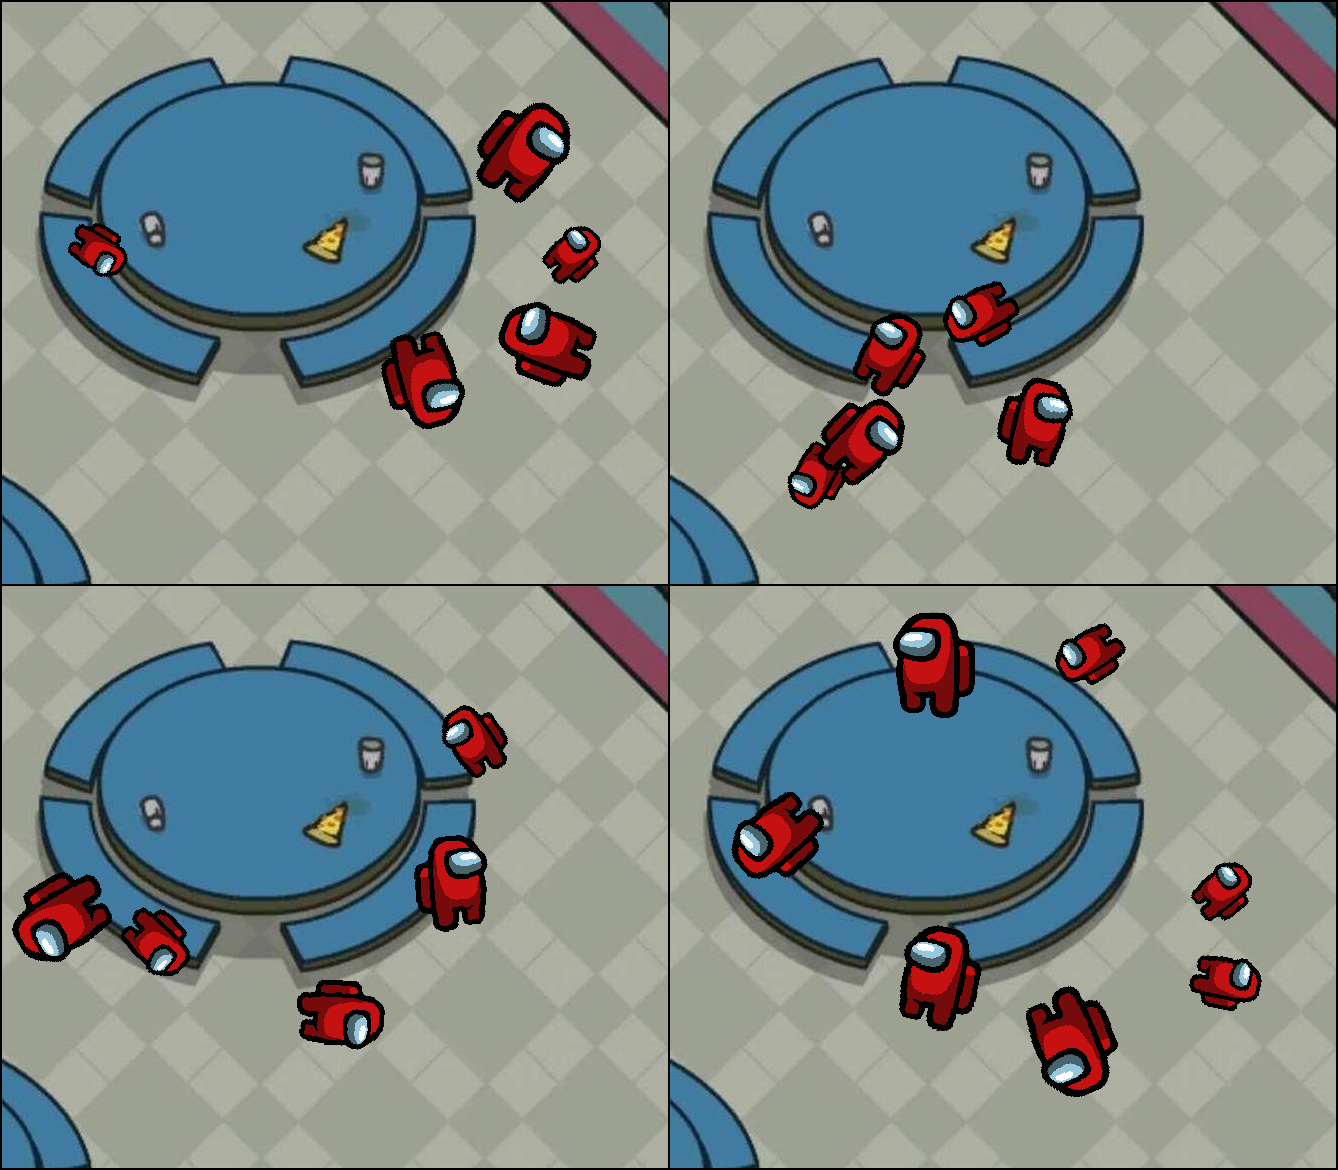

In [32]:
show(tv.utils.make_grid(sample_batch[0], nrow=2))

## Model

In [33]:
from torchvision.models import detection

In [34]:
model = detection.fasterrcnn_resnet50_fpn_v2(
    weights=detection.FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT, 
    progress=True
)
model = model.train(False)

In [35]:
sample_batch, sample_label = next(iter(train_data))
sample_batch.shape

torch.Size([4, 3, 582, 666])

In [36]:
results = model(sample_batch)
# results

In [37]:
def filter_by_score(result, threshold):
    mask = (result['labels'] == 38) & (result['scores'] >= threshold)
    return {k: v[mask] for k, v in result.items()}

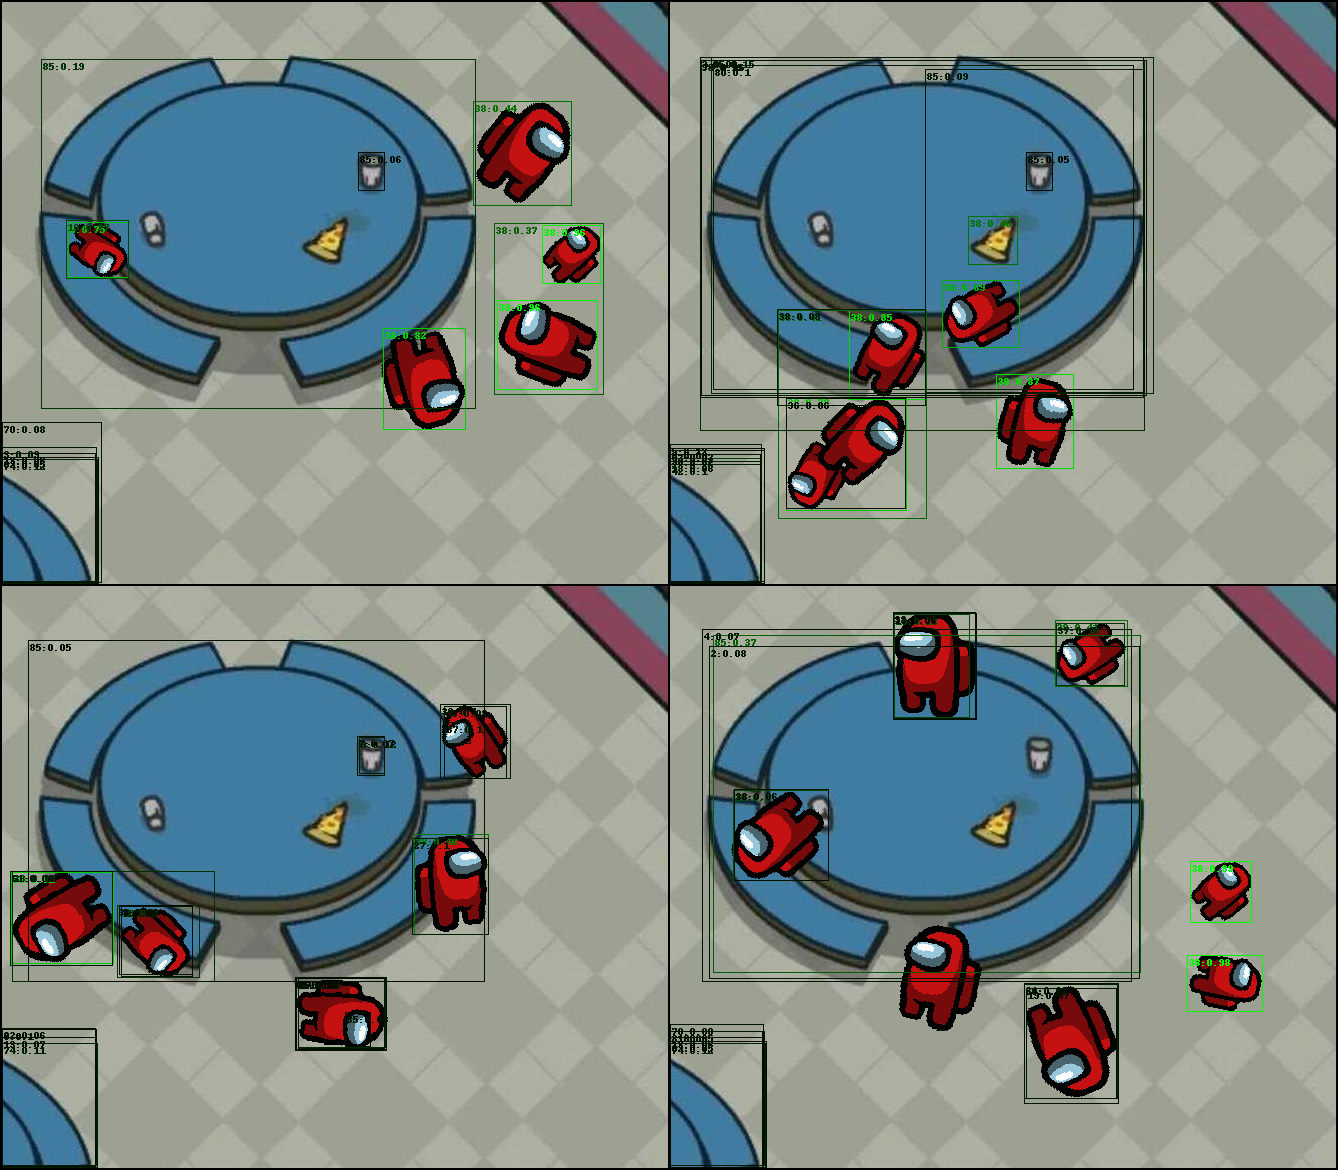

In [38]:
previews = []
for img, res in zip(sample_batch, results):
    # res = filter_by_score(res, 0.15)
    preview = tv.utils.draw_bounding_boxes(
        (255*img).to(torch.uint8), 
        res['boxes'],
        [f"{int(i)}:{np.round(float(s), 2)}" for i, s in zip(res['labels'], res['scores'])],
        colors=[(0,255*l,0) for l in res['scores']]
    )

    previews.append(preview)
    

show(tv.utils.make_grid(previews, nrow=2))

## Transfer Learning

### Replacement

In [39]:
# Replace model's head box predictor with our owns

in_features = model.roi_heads.box_predictor.cls_score.in_features # Get size of box predictor input 
new_box_predictor = detection.faster_rcnn.FastRCNNPredictor(in_features, 2) # Create new box predictor
model.roi_heads.box_predictor = new_box_predictor # Replace model's head box predictor with our owns


In [40]:
# Freeze all part which isn't a roi_heads
for name, layer in model.named_children():
    if name != "roi_heads":
        for params in layer.parameters():
            params.requires_grad = False

In [51]:
from torchmetrics.detection import MeanAveragePrecision

In [52]:
# Evaluate pre-train metrics

metrics = MeanAveragePrecision()

for imgs, targets in train_data:
    preds = model(imgs, targets)
    metrics.update(preds, targets)
    break




In [53]:
metrics.compute()

{'map': tensor(0.0165),
 'map_50': tensor(0.0858),
 'map_75': tensor(0.0011),
 'map_small': tensor(-1.),
 'map_medium': tensor(0.0532),
 'map_large': tensor(0.0134),
 'mar_1': tensor(0.),
 'mar_10': tensor(0.0136),
 'mar_100': tensor(0.2955),
 'mar_small': tensor(-1.),
 'mar_medium': tensor(0.2900),
 'mar_large': tensor(0.3500),
 'map_per_class': tensor(-1.),
 'mar_100_per_class': tensor(-1.)}

After replace head, before training


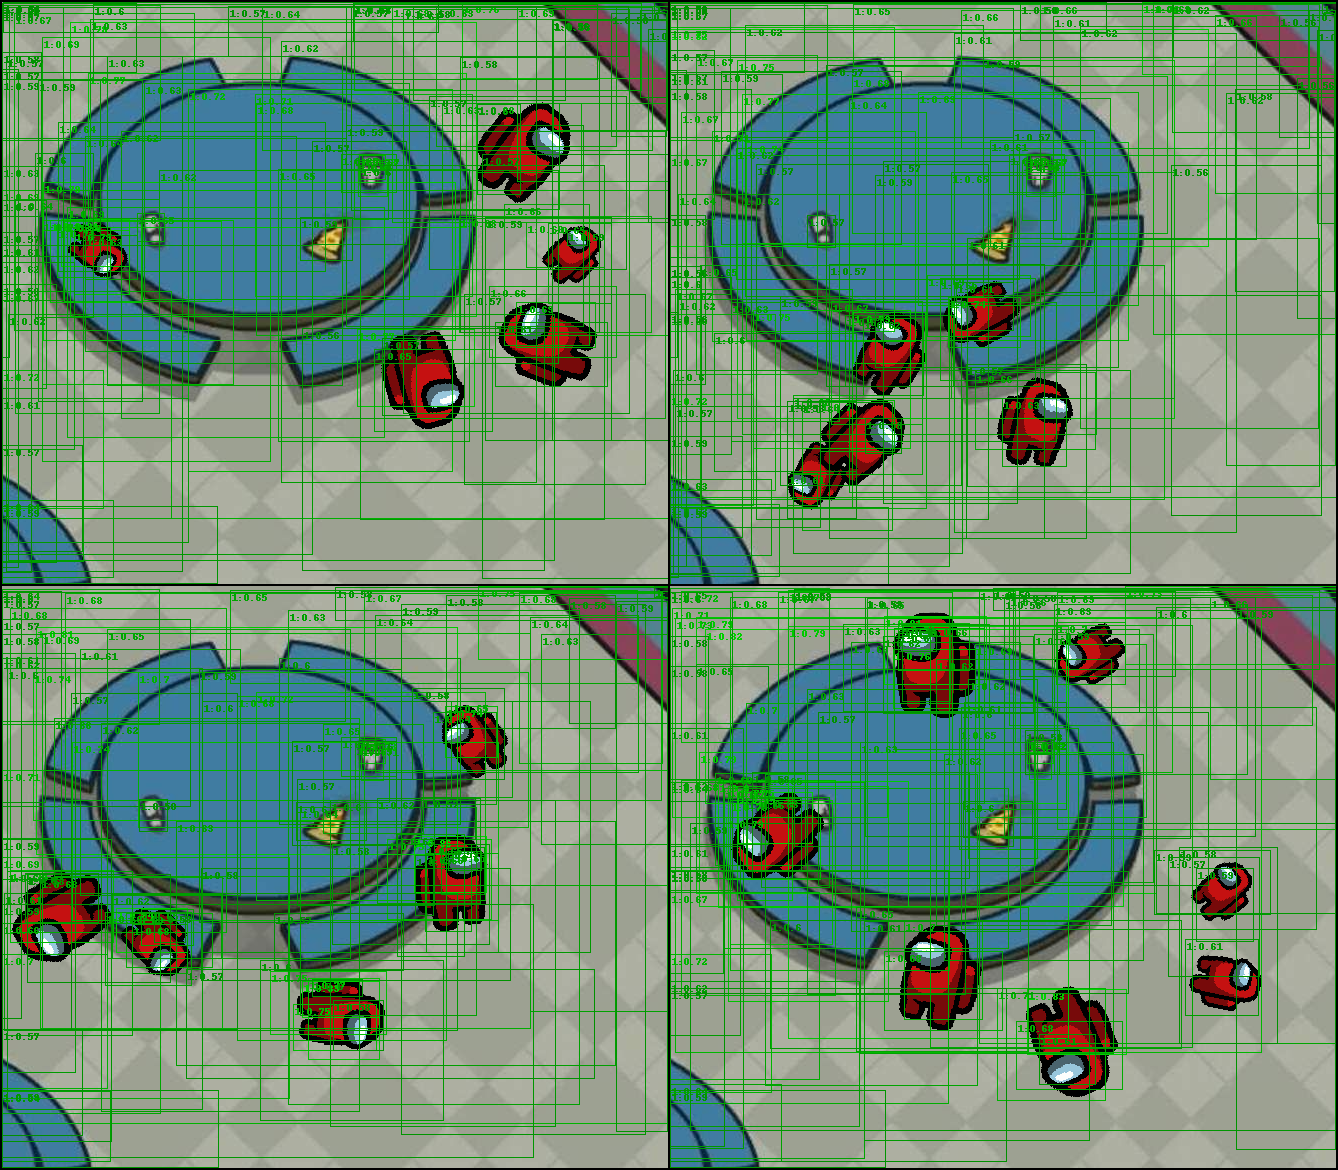

In [21]:
# Visualize a pre-train prediction

results = model(sample_batch)

previews = []
for img, res in zip(sample_batch, results):
    # res = filter_by_score(res, 0.15)
    preview = tv.utils.draw_bounding_boxes(
        (255*img).to(torch.uint8), 
        res['boxes'],
        [f"{int(i)}:{np.round(float(s), 2)}" for i, s in zip(res['labels'], res['scores'])],
        colors=[(0,255*l,0) for l in res['scores']]
    )

    previews.append(preview)
    
show(tv.utils.make_grid(previews, nrow=2))

### Training

In [23]:
# Make amoug model

class AmougModel(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model


    
    def training_step(self, batch, batch_idx):
        imgs, targets = batch
        
        losses = self.model(imgs, targets)
        loss = sum(losses.values())
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
        return optimizer


In [24]:
amoug_model = AmougModel(model)

In [26]:
trainer = pl.Trainer(limit_train_batches=100, max_epochs=1)
trainer.fit(model=amoug_model, train_dataloaders=train_data)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params
-------------------------------------
0 | model | FasterRCNN | 43.3 M
-------------------------------------
15.2 M    Trainable params
28.0 M    Non-trainable params
43.3 M    Total params
173.025   Total estimated model params size (MB)


Epoch 0:   0%|          | 0/100 [00:00<?, ?it/s] 

In [1]:
summary(amoug_model)

NameError: name 'summary' is not defined

In [31]:
losses = model(sample_batch, sample_label)

{'loss_classifier': tensor(0.7183, grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.5452, grad_fn=<DivBackward0>),
 'loss_objectness': tensor(0.0596, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.0047, grad_fn=<DivBackward0>)}

In [34]:
sum(losses.values())

tensor(1.3278, grad_fn=<AddBackward0>)